In [195]:
push!(LOAD_PATH, "./")
using Plots
using Bspline
using FastGaussQuadrature
# 条件
C = 1.0    # 弾性定数
s = 0.1   # 表面力
U = 0.0   # Dirichlet境界条件の変位

0.0

In [196]:
# B-spline関数のリファインメント
function pref(pi,p,k)    # pi:リファインメント前の次数, p:リファインメント後の次数
    l = k[1]
    r = k[end]
    n = p-pi
    prepend!(k,[l for i in 1:n])
    append!(k,[r for i in 1:n])
end
function href(p,k,N)    # N:リファインメント後の基底関数の個数
    for i in 1:N-p-1
        insert!(k,p+1+i,i/(N-p))
    end
end

# 初期の基底関数
pi = 1
ki = [0.0, 0.0, 1.0, 1.0]    # 1の分割(p+1回連続)

# リファインメント後の基底関数
N = 50
p = 3
k = copy(ki)
pref(pi,p,k)
href(p,k,N)
k

54-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.02127659574468085
 0.0425531914893617
 0.06382978723404255
 0.0851063829787234
 0.10638297872340426
 0.1276595744680851
 0.14893617021276595
 0.1702127659574468
 0.19148936170212766
 ⋮
 0.8297872340425532
 0.851063829787234
 0.8723404255319149
 0.8936170212765957
 0.9148936170212766
 0.9361702127659575
 0.9574468085106383
 0.9787234042553191
 1.0
 1.0
 1.0
 1.0

In [197]:
function INT2(f,a,b,nip) # 被積分関数f，区間[a,b]，積分点の個数nipを引数にとり，積分値を返す
    I = 0
    nodes,weights = gausslegendre(nip)
    for i in 1:nip
        I += f((b-a)/2*nodes[i]+(a+b)/2)*weights[i]
    end
    I *= (b-a)/2
    return I
end

INT2 (generic function with 1 method)

In [198]:
# 剛性行列の作成
L = 2.0 # x=2t-1
nip = 3 # (p+1)/2以上
K = zeros(Float64, (N,N))
for α in 1:N
    for β in 1:N
        g(t) = C*Ḃs(β,p,k,t)*(1/L)*Ḃs(α,p,k,t) # 被積分関数
        for m in 1:length(k)-1
            K[α,β] += INT2(g,k[m],k[m+1],nip)
        end
    end
end
K

50×50 Array{Float64,2}:
  42.3     -29.9625   -11.1625    …    0.0         0.0        0.0
 -29.9625   35.25       0.88125        0.0         0.0        0.0
 -11.1625    0.88125   15.8625         0.0         0.0        0.0
  -1.175    -5.875     -0.783333       0.0         0.0        0.0
   0.0      -0.29375   -4.60208        0.0         0.0        0.0
   0.0       0.0       -0.195833  …    0.0         0.0        0.0
   0.0       0.0        0.0            0.0         0.0        0.0
   0.0       0.0        0.0            0.0         0.0        0.0
   0.0       0.0        0.0            0.0         0.0        0.0
   0.0       0.0        0.0            0.0         0.0        0.0
   0.0       0.0        0.0       …    0.0         0.0        0.0
   0.0       0.0        0.0            0.0         0.0        0.0
   0.0       0.0        0.0            0.0         0.0        0.0
   ⋮                              ⋱                         
   0.0       0.0        0.0            0.0         0.0   

In [199]:
# 体積力、表面力の計算
F = zeros(Float64, N) # 体積力
H = zeros(Float64, N) # 表面力
for α in 1:N
    f(t) = -2*t+1 # 体積力f(x)=-x, x=2t-1
    h(t) = f(t)*Bs(α,p,k,t)*L
    for m in 1:length(k)-1
        F[α] += INT2(h,k[m],k[m+1],nip)
    end
end
H[N] = s
F

50-element Array{Float64,1}:
  0.01054775916704391
  0.020733363512901764
  0.030285196921684018
  0.03893164327750113
  0.03712086917157085
  0.03531009506564056
  0.033499320959710276
  0.031688546853779996
  0.02987777274784969
  0.028066998641919434
  0.026256224535989126
  0.02444545043005886
  0.022634676324128567
  ⋮
 -0.02444545043005888
 -0.026256224535989164
 -0.028066998641919364
 -0.02987777274784976
 -0.03168854685377996
 -0.03349932095971025
 -0.03531009506564063
 -0.03712086917157077
 -0.038931643277501184
 -0.030285196921684077
 -0.02073336351290176
 -0.010547759167043829

In [200]:
# Dirichlet境界条件
# 右辺ベクトル
b = zeros(Float64,N)
b[1] = U
for α in 2:N
    b[α] = F[α]+H[α]-K[α,1]*U
end
# 剛性行列
K[1,:] .= 0.0
K[:,1] .= 0.0
K[1,1] = 1.0

# 連立方程式
u = zeros(Float64,N)
u = K\b # パラメータ空間上での解

50-element Array{Float64,1}:
  0.0
  0.001418439716312142
  0.0036517277802929947
  0.00526793998760762
  0.005227486523539219
  0.0036074216053614216
  0.0004847994503478482
 -0.00406332572422785
 -0.00995989970109208
 -0.017127868262971167
 -0.025490177192591532
 -0.0349697722726795
 -0.04548959928596147
  ⋮
 -0.4316968943939745
 -0.4411764894740625
 -0.44953879840368305
 -0.45670676696556217
 -0.4626033409424265
 -0.4671514661170022
 -0.47027408827201594
 -0.4718941531901939
 -0.47193460665426235
 -0.47031839444694806
 -0.46808510638296724
 -0.4666666666666552

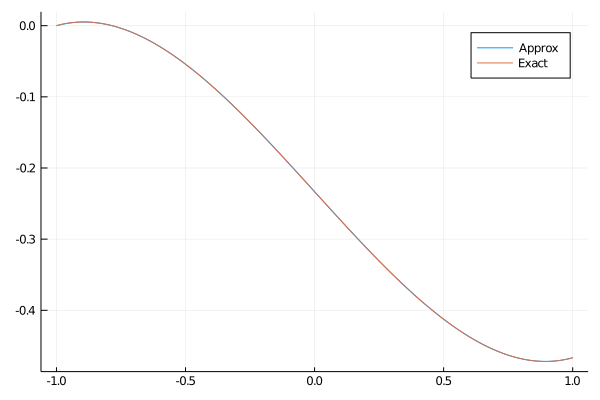

In [201]:
# 計算結果の出力
tl = 400
t = collect(range(1.0e-10,stop=1.0-1.0e-10, length=tl))
x = collect(range(-1.0+1.0e-10,stop=1.0-1.0e-10, length=tl))

# 各種の力学量
u1 = zeros(Float64,tl)    # 変位
Strain = zeros(Float64,tl)    # ひずみ
Stress = zeros(Float64,tl)    # 応力
for i in 1:tl
    u1[i] = sum(Bs(α,p,k,t[i])*u[α] for α in 1:N)
    Strain[i] = sum(Ḃs(α,p,k,t[i])*u[α] for α in 1:N)/L
    Stress[i] = sum(C*Ḃs(α,p,k,t[i])*u[α] for α in 1:N)/L
end

# 材料力学の解
function u2(x)
    c1 = (s-0.5)/C
    c2 = U+1.0/(6.0*C)+(s-0.5)/C
    return 1.0/(6.0*C)*x^3+c1*x+c2
end

plot(x,u1,label="Approx")
plot!(x,u2,label="Exact")

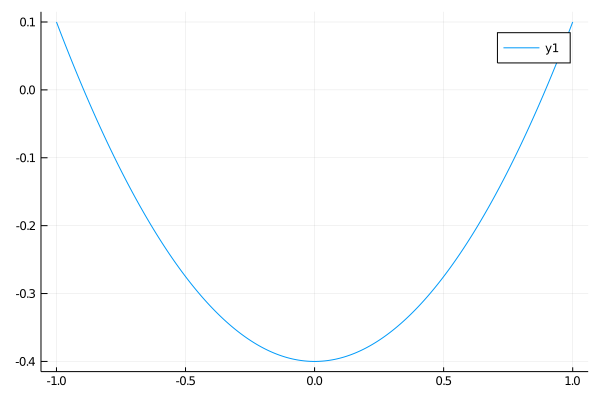

In [202]:
plot(x,Strain)

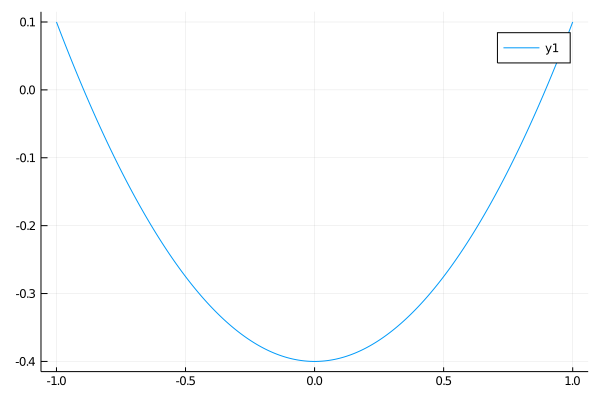

In [203]:
plot(x,Stress)

In [204]:
#=
# リファインメント後の制御点を求める(1次元)
function refinementcp(ai,pi,ki,p,k)
    Ni = length(ki)-pi-1    # 2
    N = length(k)-p-1    # 50
    a = zeros(Float64,N)

    # Cijを求める
    κ = [k[i]*(N-i)/(N+1)+k[i+p+1]*(i+1)/(N+1) for i in 1:N]
    A = [Bs(j,p,k,κ[i]) for i in 1:N, j in 1:N]
    x = zeros(Float64,N)
    C = zeros(Float64,(Ni,N))
    for i in 1:Ni
        b = [Bs(i,pi,ki,κ[j]) for j in 1:N]
        x = A\b
        for j in 1:N
            C[i,j] = x[j]
        end
    end

    # 制御点を求める
    for i in 1:N
        a[i] = sum(C[j,i]*ai[j] for j in 1:Ni)
    end
    return a
end

# 初期の制御点
ai = [-1.0, 1.0]

# リファインメント後の制御点
a = zeros(Float64,M)
a = refinementcp(ai,pi,ki,p,k)
=#